## Simulate and fit DCE-MRI

In [1]:
import sys
sys.path.append('..\\src')
sys.path.append('..\\..\\DCE-DSC-MRI_CodeCollection\\src')
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

---
### Concentration-time data

parameter: value (ground truth)
vp: 0.010057 (0.010000)
ps: 0.000510 (0.000500)
ve: 0.577961 (0.200000)
fp: 20.336099 (20.000000)


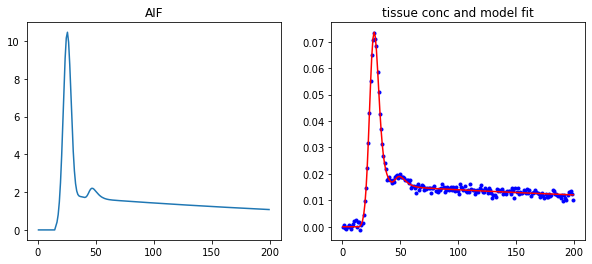

In [194]:
from dce import aifs, pk_models, dce_fit

# define timepoints
dt = 1.
t = np.arange(0,200)*dt + dt/2

# define AIF, pharmacokinetic model and noise level
aif = aifs.parker(hct=0.42, t_start=15.)
pk_pars = {'vp': 0.01, 'ps': 5e-4, 've': 0.2, 'fp': 20, 'ktrans': 5e-2}
pk_model = pk_models.tcxm(t, aif) # <-- CHANGE THE MODEL HERE
noise = 0.001

# generate "measured" concentration with noise
c_t, _c_cp, _c_e = pk_model.conc(**pk_pars)
c_t += np.random.normal(loc = 0., scale = noise, size = c_t.shape)

# fit measured concentration using the same pharmacokinetic model
fit_opts = {'pk_pars_0': {'vp': 0.01, 'ps': 5e-2, 've': 0.2, 'fp': 80, 'ktrans': 1e-4}}
pk_pars_fit, c_t_fit = dce_fit.conc_to_pkp(c_t, pk_model, fit_opts)

print("parameter: value (ground truth)")
[ print(f"{key}: {val:.6f} ({pk_pars[key]:.6f})") for key, val in pk_pars_fit.items() ]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(t, aif.c_ap(t));
ax[0].set_title('AIF');
ax[1].plot(t, c_t, 'b.', t, c_t_fit, 'r-');
ax[1].set_title('tissue conc and model fit');

In [328]:
a=np.array([[1,0,1,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]])
b=np.array([1,2,3,4])
a*b

array([[1, 0, 3, 0],
       [1, 0, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 4]])

---
### Signal-time data